### the empirical distribution of paywall hits 

In [67]:
library(ggplot2)
library(foreach)
library(doParallel)
registerDoParallel(cores=2)

In [36]:
dist = data.frame(hits = c(0:2,'3+'), 
                  fraction = c(.21,.31,.15,.33))

In [37]:
dist

hits,fraction
<fct>,<dbl>
0,0.21
1,0.31
2,0.15
3+,0.33


### treatment options at each step 
* A: $1 for 2 months

* B: $1 for 4 months 

* C1: $1 for 6 months (the current price), "stay informed" (the same as A and B) 

* C2: $1 for 6 months (the current price), "you have been selected" (the status quo)

In [38]:
# total number of visitors
n = 600000

# conversion rate of the status quo
q = 0.003
# treatment effect on conversion rate
tau_q = -0.0005

# average 1-year revenue per user conditional on conversion under the status quo 
# suppose on average users survive for 3 months after the discount ends
rev = 1 + 6.99 * 4 * 3

# treatment effect on revenue conditional on conversion 
# assuming the same survival time across conditions
# 120 is the revenue difference between $1 for 2 months and the status quo
# 60 is the revenue difference between $1 for 4 months and the status quo
tau_rev = 100

In [39]:
# true expected revenue difference 
(q+tau_q)*(rev+tau_rev) - q*rev

[1] 0.20756

In [40]:
# fraction of users to assign to the status quo
p = 0.5

In [41]:
# a total of 54 sequences with different permutation of (A,B,C1) and (A,B,C2)
treatment = paste0('t',seq(1:54))
prob = c(p,rep((1-p)/53,53))

In [42]:
treat = sample(treatment,n,prob = prob,replace = T)

In [43]:
table(treat)

treat
    t1    t10    t11    t12    t13    t14    t15    t16    t17    t18    t19 
300284   5625   5828   5613   5582   5607   5742   5616   5736   5580   5644 
    t2    t20    t21    t22    t23    t24    t25    t26    t27    t28    t29 
  5754   5609   5651   5615   5710   5843   5738   5518   5729   5747   5619 
    t3    t30    t31    t32    t33    t34    t35    t36    t37    t38    t39 
  5705   5687   5663   5723   5750   5726   5624   5616   5598   5645   5692 
    t4    t40    t41    t42    t43    t44    t45    t46    t47    t48    t49 
  5655   5678   5621   5583   5727   5640   5630   5507   5698   5596   5438 
    t5    t50    t51    t52    t53    t54     t6     t7     t8     t9 
  5635   5674   5563   5748   5656   5587   5757   5680   5628   5480 

In [44]:
y = ifelse(treat == 't1', 
           sample(c(0,rev),n,prob=c(1-q,q),replace=T), 
           sample(c(0,rev+tau_rev),n,prob=c(1-(q+tau_q),q+tau_q),replace=T))

In [45]:
table(y)

y
     0  84.88 184.88 
598316    910    774 

In [46]:
df = data.frame(y = y, treat = treat, prob = ifelse(treat == 't1',p,(1-p)/53))

In [47]:
summary(lm(y ~ treat, weights = 1/prob, data = df))$coefficient[2,4]

[1] 0.007522386

### putting it into a function

In [74]:
power <- function(p = 0.5, n = 600000,
                 q = 0.003, rev = 1 + 6.99 * 4 * 3,
                 tau_q = -0.0005, tau_rev = 100) {
    
#print(c(p,n,q,tau_q,rev,tau_rev))
    
treatment = paste0('t',seq(1:54))
prob = c(p,rep((1-p)/53,53))
    
treat = sample(treatment,n,prob = prob,replace = T)
    
y = ifelse(treat == 't1', 
           sample(c(0,rev),n,prob=c(1-q,q),replace=T), 
           sample(c(0,rev+tau_rev),n,prob=c(1-(q+tau_q),q+tau_q),replace=T))
    
df = data.frame(y = y, treat = treat, prob = ifelse(treat == 't1',p,(1-p)/53))

# p_value for a given condition
p_value = summary(lm(y ~ treat, weights = 1/prob, data = df))$coefficient[2,4]
    
return(p_value)

}

In [59]:
power()

[1]  5.000e-01  6.000e+05  3.000e-03 -5.000e-04  8.488e+01  1.000e+02


[1] 0.1211541

In [81]:
k = 100

foreach(i = 1:k, .combine = c) %dopar% {
    
    power(p = 0.2, n = 600000,
          q = 0.003, rev = 1 + 6.99 * 4 * 3,
          tau_q = 0, tau_rev = 100)
    
} -> result 

In [82]:
mean(result <= 0.05)

[1] 0.61

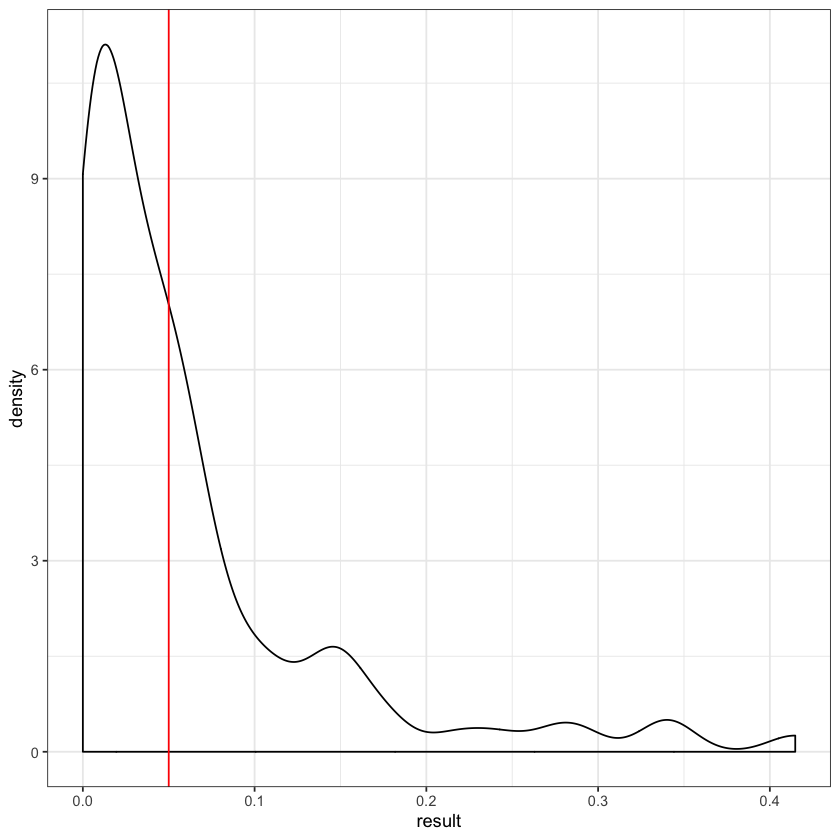

In [83]:
ggplot(aes(result),data = data.frame(result = result)) + geom_density() + 
geom_vline(xintercept = 0.05, color = "red") + theme_bw()